### Primera prueba de modelo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Cargar el archivo CSV limpio
file_path = 'data_CLEAN.csv' 
df_clean = pd.read_csv(file_path)

# Variables predictoras y objetivo
X = df_clean[['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'neighborhood', 'real_state']]
y = df_clean['price']

# Convertir las variables categóricas en numéricas con One-Hot Encoding
categorical_features = ['neighborhood', 'real_state']

# Crear un preprocesador con OneHotEncoder para las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Dividir el dataset en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost en un pipeline con el preprocesador
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Definir los hiperparámetros a ajustar en RandomizedSearchCV
param_distributions = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3]
}

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search_xgb = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_distributions, 
    n_iter=50,  # Número de iteraciones aleatorias
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='neg_mean_squared_error',  # Métrica para optimizar
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Entrenar RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados y entrenar el modelo final
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Calcular las medidas de precisión del modelo ajustado
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Mostrar las nuevas medidas de precisión
precision_measures_xgb = {
    'RMSE': rmse_xgb,
    'MAE': mae_xgb,
    'R2 Score': r2_xgb
}
print("Medidas de precisión del modelo XGBoost ajustado:", precision_measures_xgb)

# Visualizar la comparación entre los valores reales y los predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, linestyle='--')
plt.title('Comparación de Valores Reales vs. Predichos (XGBoost Ajustado)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()

### Segunda prueba de modelo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Cargar el archivo CSV limpio
file_path = 'data_CLEAN.csv' 
df_clean = pd.read_csv(file_path)

# Crear nuevas características: densidad de habitaciones (rooms per square meter)
df_clean['rooms_per_square_meter'] = df_clean['rooms'] / df_clean['square_meters']

# Aplicar una transformación logarítmica al precio para reducir el impacto de outliers
df_clean['log_price'] = np.log1p(df_clean['price'])

# Variables predictoras y objetivo (usando el log del precio)
X = df_clean[['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'neighborhood', 'real_state', 'rooms_per_square_meter']]
y = df_clean['log_price']

# Definir las características categóricas y numéricas
categorical_features = ['neighborhood', 'real_state']
numerical_features = ['rooms', 'bathroom', 'square_meters', 'rooms_per_square_meter']

# Crear un preprocesador con OneHotEncoder y StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Dividir el dataset en conjunto de entrenamiento y prueba (80/20) con estratificación por barrio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_clean['neighborhood'])

# Crear el modelo XGBoost en un pipeline con el preprocesador
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Definir los hiperparámetros a ajustar en RandomizedSearchCV con un rango más amplio
param_distributions = {
    'model__n_estimators': [100, 200, 300, 500, 800],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3]
}

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search_xgb = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_distributions, 
    n_iter=100,  # Aumentar el número de iteraciones
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='neg_mean_squared_error', 
    random_state=42,
    n_jobs=-1
)

# Entrenar RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados y entrenar el modelo final
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Invertir la transformación logarítmica para evaluar las métricas en escala original
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_xgb)

# Calcular las medidas de precisión del modelo ajustado en la escala original
rmse_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_xgb = mean_absolute_error(y_test_original, y_pred_original)
r2_xgb = r2_score(y_test_original, y_pred_original)

# Mostrar las nuevas medidas de precisión
precision_measures_xgb = {
    'RMSE': rmse_xgb,
    'MAE': mae_xgb,
    'R2 Score': r2_xgb
}
print("Medidas de precisión del modelo XGBoost ajustado:", precision_measures_xgb)

# Visualizar la comparación entre los valores reales y los predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', linewidth=2, linestyle='--')
plt.title('Comparación de Valores Reales vs. Predichos (XGBoost Mejorado)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()

### LightGBM test

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


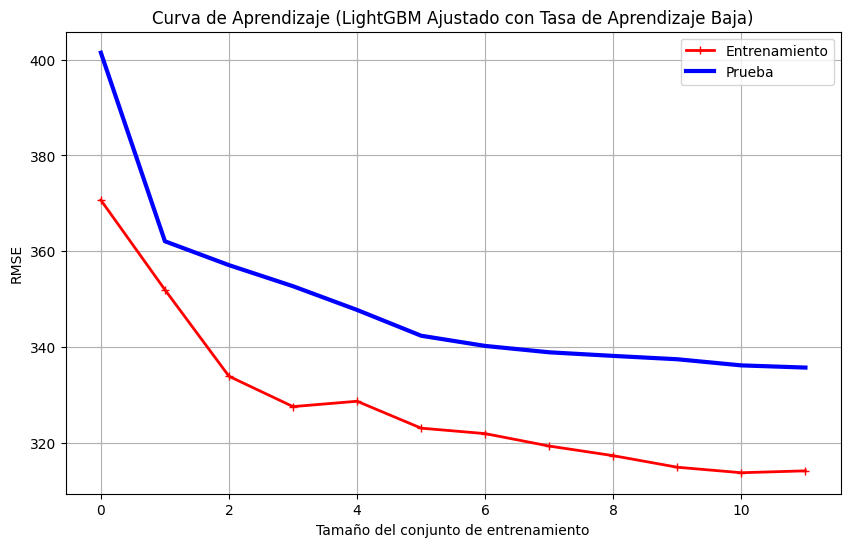

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

# Cargar el archivo CSV limpio
file_path = 'data_CLEAN.csv' 
df_clean = pd.read_csv(file_path)

# Crear nuevas características: densidad de habitaciones (rooms per square meter)
df_clean['rooms_per_square_meter'] = df_clean['rooms'] / df_clean['square_meters']

# Aplicar una transformación logarítmica al precio para reducir el impacto de outliers
df_clean['log_price'] = np.log1p(df_clean['price'])

# Variables predictoras y objetivo (usando el log del precio)
X = df_clean[['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'neighborhood', 'real_state', 'rooms_per_square_meter']]
y = df_clean['log_price']

# Definir las características categóricas y numéricas
categorical_features = ['neighborhood', 'real_state']
numerical_features = ['rooms', 'bathroom', 'square_meters', 'rooms_per_square_meter']

# Crear un preprocesador con OneHotEncoder y StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Dividir el dataset en conjunto de entrenamiento y prueba (80/20) con estratificación por barrio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_clean['neighborhood'])

# Crear el modelo LightGBM en un pipeline con el preprocesador, aplicando más regularización y ajustes para reducir overfitting
lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(objective='regression', random_state=42, 
                            lambda_l1=1.0, lambda_l2=1.0, 
                            min_data_in_leaf=50, max_depth=5, 
                            min_split_gain=0.05, bagging_fraction=0.9, 
                            bagging_freq=1, learning_rate=0.01))
])

# Entrenar el modelo en incrementos para generar la curva de aprendizaje
train_errors = []
test_errors = []

# Usar incrementos mayores, como 200 datos
for m in range(200, len(X_train), 500):
    lgbm_model.fit(X_train[:m], y_train[:m])
    y_train_predict = lgbm_model.predict(X_train[:m])
    y_test_predict = lgbm_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train[:m]), np.expm1(y_train_predict)))
    test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_predict)))
    
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_errors, "r-+", linewidth=2, label="Entrenamiento")
plt.plot(test_errors, "b-", linewidth=3, label="Prueba")
plt.title('Curva de Aprendizaje (LightGBM Ajustado con Tasa de Aprendizaje Baja)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()